# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [4]:
import monty
%run monty.py 10  # argument after monty.py dictates how long the recording will last


* Email sent.


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

** Let's look at the .aif files. **

In [2]:
!ls *.aif

1.aif                 4.aif                 A4_PopOrgan.aif
10.aif                5.aif                 C4+A4_PopOrgan.aif
11.aif                6.aif                 F3_PopOrgan.aif
12.aif                7.aif                 F4_CathedralOrgan.aif
2.aif                 8.aif
3.aif                 9.aif


In [3]:
!afplay 1.aif

** Import the required modules. **

In [4]:
import aifc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.signal import spectrogram, gaussian

sns.set(style="white", context="poster")
%matplotlib notebook

** First I need to know which notes correspond to which frequency. The following
data assumes $A_4$ is tuned to 440 Hz, which seems to match our example data.**

In [5]:
# Grab data from some webpage I found
notes_df = pd.read_html("https://pages.mtu.edu/~suits/notefreqs.html")[1]

# Do some formatting on the dataframe
notes_df.set_index([0], inplace=True)
notes_df.rename(columns={1:"Frequency (Hz)", 2:"Wavelength (cm)"}, inplace=True)
notes_df.drop("Note", inplace=True)

# Take a peak
notes_df.head(1)

,Frequency (Hz),Wavelength (cm)
0,,
C0,16.35,2109.89


** Now let's write the functions to actually perform the required task. **

In [6]:
def get_data(filename):
    '''
    Pass in an aifc file loc and this wil return a numpy array with the
    corresponding data, dtype=np.int32, as well as the number of frames
    and the frame rate.
    '''
    
    with aifc.open(filename, "rb") as file:
        nframes = file.getnframes()
        framerate = file.getframerate()
        signal = file.readframes(nframes)

    y = np.frombuffer(signal, dtype=np.int32).byteswap()
    
    return nframes, framerate, y

In [7]:
def plot_data(audio_data, nframes, framerate, title=None):
    '''
    Pass in audio_data as well as the corresponding number of frames and 
    frame rate and this will plot the data as a matplotlib power specgram.
    
    Returns the frequency array and power spectrum (as returned by specgram).
    '''
    
    plt.close()  # just in case figure opened somewhere else in notebook
    plt.figure()
    Pxx, freqs, bins, im = plt.specgram(audio_data, NFFT=nframes, 
                                        Fs=framerate, cmap=plt.cm.viridis,
                                        pad_to=int(1e5),
                                        window = gaussian(nframes,1e6))
                                        
    plt.ylim(1,900)
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.tight_layout()  # Prevent labels from getting cut off in notebook
    if not title is None:
        plt.title(title)
    plt.show()
    
    return freqs, Pxx

In [8]:
def get_peak_freqs(freqs, Pxx, dB=-10, df=notes_df):
    '''
    Pass in frequency array and corresponding power spectrum array. 
    
    Also takes kwarg 'dB' (default: -10), which determines the cutoff for 
    frequencies to be registered relative to the maximum peak. I.e. if
    db = -10, then only frequency peaks greater than 10% of the intensity of
    the dominant frequency will be considered.
    
    And takes kwarg 'df', which corresponds to a pandas dataframe used to 
    translate frequency values to notes.
    
    Returns the notes corresponding to the dominant frequencies and their 
    relative amplitudes.
    '''
    
    power_ratio = 10**(dB / 10)  # Convert dB to ratio of powers
    
    max_value = np.argmax(Pxx)  # get max intensity value
    
    # Get the number of items greater than the cutoff threshold
    n = len(np.where(Pxx > power_ratio * max_value))
   
    # Get the indices of the peaks above the threshold and sort them
    ind = np.argpartition(Pxx, -n, axis=None)[-n:]
    ind[np.argsort(Pxx[ind])]
    
    print(freqs[ind])
    

<IPython.core.display.Javascript object>


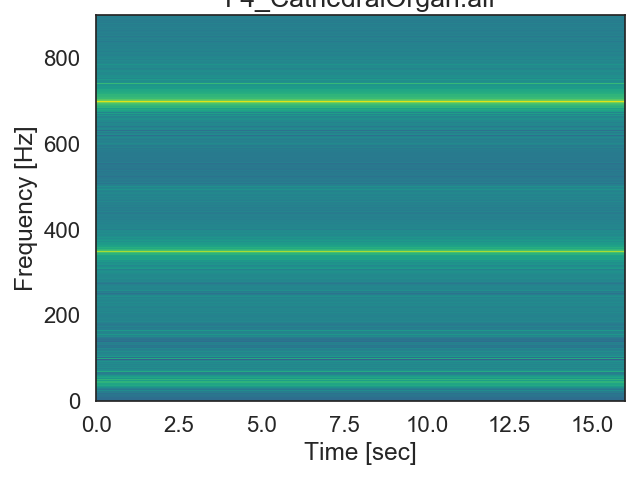

[1046.052  698.103]


In [9]:
filename = "F4_CathedralOrgan.aif"
nframes, framerate, y = get_data(filename)
freqs, Pxx = plot_data(y, nframes, framerate, title=filename)
get_peak_freqs(freqs, Pxx)

In [10]:
notes_df.loc["F4", "Frequency (Hz)"]

'349.23'

In [146]:
np.argmax(Pxx)

2793

In [147]:
freqs[2793]

174.5625

In [11]:
divmod(1046.052, 349.23)

(2.0, 347.59199999999987)

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.